In [10]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

# Parameters
train_folder = 'train'
test_folder = 'test'
class_folders = ['candy_store', 'forest_broadleaf', 'stadium_football']
patch_size = 32
bins = 8
k = 32  # Number of clusters for K-means

# Patch extraction function
def extract_patches(image, patch_size=32):
    patches = []
    width, height = image.size
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image.crop((j, i, j + patch_size, i + patch_size))
            if patch.size == (patch_size, patch_size):
                patches.append(np.array(patch))
    return patches

# Color histogram extraction function
def color_histogram(patch, bins=8):
    hist_r = np.histogram(patch[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(patch[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(patch[:, :, 2], bins=bins, range=(0, 256))[0]
    return np.concatenate([hist_r, hist_g, hist_b])

# K-means implementation from scratch
def initialize_centroids(features, k):
    indices = np.random.choice(len(features), k, replace=False)
    return features[indices]

def assign_clusters(features, centroids):
    distances = np.linalg.norm(features[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(features, labels, k):
    new_centroids = np.zeros((k, features.shape[1]))
    for i in range(k):
        points_in_cluster = features[labels == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
    return new_centroids

def kmeans(features, k, max_iter=100, tol=1e-4):
    centroids = initialize_centroids(features, k)
    for _ in range(max_iter):
        labels = assign_clusters(features, centroids)
        new_centroids = update_centroids(features, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels

# BoVW representation for an image
def bovw_representation(image_patches, centroids):
    features = [color_histogram(patch) for patch in image_patches]
    features = np.array(features)
    labels = assign_clusters(features, centroids)
    bovw_hist = np.bincount(labels, minlength=len(centroids))
    return bovw_hist / len(features)

# Save data function
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load data function
def load_data(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

# Process images and save BoVW representations for each class separately
def process_images(folder, class_folders, centroids, save_folder, prefix):
    for i, class_name in enumerate(class_folders, 1):
        class_folder = os.path.join(folder, class_name)
        class_data = []
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = Image.open(img_path)
            patches = extract_patches(img, patch_size)
            bovw_vector = bovw_representation(patches, centroids)
            class_data.append((img_name, bovw_vector, class_name))
        
        # Save each class data in a separate file for each image
        for j, data in enumerate(class_data, 1):
            img_name, bovw_vector, class_name = data
            save_data(bovw_vector, os.path.join(save_folder, f'{prefix}_data{i}_{j}.pkl'))

# Main workflow
def main():
    # Check if BoVW data exists; if not, process it
    if not os.path.exists('train_data1_1.pkl'):
        # Collect all patches from training images to fit K-means
        all_train_features = []
        for class_name in class_folders:
            class_folder = os.path.join(train_folder, class_name)
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                img = Image.open(img_path)
                patches = extract_patches(img, patch_size)
                for patch in patches:
                    all_train_features.append(color_histogram(patch))

        all_train_features = np.array(all_train_features)
        print("Total training patches:", len(all_train_features))

        # Apply K-means clustering
        centroids, _ = kmeans(all_train_features, k)
        print("K-means clustering completed.")

        # Process train and test datasets and save each class separately
        process_images(train_folder, class_folders, centroids, os.getcwd(), prefix='train')
        process_images(test_folder, class_folders, centroids, os.getcwd(), prefix='test')
        
        print("BoVW representations saved for each class.")
    else:
        print("BoVW data already exists.")

if __name__ == "__main__":
    main()


BoVW data already exists.


In [11]:
import pickle
import os

# Initialize empty lists to store train and test data for each class
train_data1, train_data2, train_data3 = [], [], []
test_data1, test_data2, test_data3 = [], [], []

# Loop through all pickle files in the current directory
for filename in os.listdir('.'):
    if filename.endswith('.pkl'):
        # Load the pickle file
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        
        # Determine which class the file belongs to based on the filename
        if 'train_data1_' in filename:
            train_data1.append(data)
        elif 'train_data2_' in filename:
            train_data2.append(data)
        elif 'train_data3_' in filename:
            train_data3.append(data)
        elif 'test_data1_' in filename:
            test_data1.append(data)
        elif 'test_data2_' in filename:
            test_data2.append(data)
        elif 'test_data3_' in filename:
            test_data3.append(data)

print("Data concatenation and completed.")


Data concatenation and completed.


In [12]:
print(len(train_data1))

50


In [13]:
import numpy as np

def initialize_centroids(data, k):
    # Randomly select k unique points from the data as the initial centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    return centroids

def assign_clusters(data, centroids):
    # Assign each data point to the nearest centroid
    clusters = []
    for point in data:
        # Compute the Euclidean distance between the point and each centroid
        distances = np.linalg.norm(point - centroids, axis=1)
        # Assign the point to the cluster with the closest centroid
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(data, clusters, k):
    # Update centroids by computing the mean of points in each cluster
    centroids = []
    for i in range(k):
        # Get the points assigned to cluster i
        cluster_points = data[clusters == i]
        # Compute the mean of the points in the cluster
        if len(cluster_points) > 0:
            new_centroid = np.mean(cluster_points, axis=0)
        else:
            new_centroid = np.zeros(data.shape[1])
        centroids.append(new_centroid)
    return np.array(centroids)

def compute_distortion(data, centroids, clusters):
    # Compute the total distortion (sum of squared distances from each point to its centroid)
    distortion = 0
    for i, point in enumerate(data):
        centroid = centroids[clusters[i]]
        distortion += np.sum((point - centroid) ** 2)
    return distortion

def k_means_clustering(k, data, tolerance=1e-4):
    # Initialize centroids
    centroids = initialize_centroids(data, k)
    
    # Initialize distortion to a large value
    previous_distortion = float('inf')
    
    while True:
        # Assign clusters based on current centroids
        clusters = assign_clusters(data, centroids)
        
        # Update centroids
        centroids = update_centroids(data, clusters, k)
        
        # Compute the current distortion
        current_distortion = compute_distortion(data, centroids, clusters)
        
        # Check if the change in distortion is below the threshold
        if np.abs(previous_distortion - current_distortion) < tolerance:
            break
        
        # Update the previous distortion
        previous_distortion = current_distortion
    
    return centroids, clusters

def compute_cluster_covariance_and_weight(data, centroids, clusters):
    """
    Computes covariance matrices and weights for each cluster in multi-dimensional data.
    This function assumes data can be multi-dimensional (more than 2D).
    
    Parameters:
    - data: Multi-dimensional dataset, where each row is a data point.
    - centroids: Centroid positions for each cluster.
    - clusters: Cluster assignment for each point.
    
    Returns:
    - covariance_matrices: List of covariance matrices for each cluster.
    - weights: List of weights (proportion of data points in each cluster).
    """
    k = len(centroids)  # Number of clusters
    total_points = len(data) 
    
    covariance_matrices = []
    weights = []
    
    for i in range(k):
        cluster_points = data[clusters == i]
        num_points_in_cluster = len(cluster_points)
        
        if num_points_in_cluster > 1:
            # Compute covariance matrix for multi-dimensional data
            cov_matrix = np.cov(cluster_points, rowvar=False)
        else:
            # If there's only 1 point, return a zero matrix of the correct shape
            cov_matrix = np.zeros((data.shape[1], data.shape[1]))
        
        weight = num_points_in_cluster / total_points
        
        # Store the results
        covariance_matrices.append(cov_matrix)
        weights.append(weight)
    
    return covariance_matrices, weights


In [14]:
from scipy.stats import multivariate_normal

def fit_k_gaussians(data, centroids, cov_matrices, cluster_weights, tolerance=1e-5):
    log_likelihoods = []
    n_samples, n_features = data.shape
    n_clusters = len(centroids)

    while True:
        responsibilities = np.zeros((n_samples, n_clusters))

        # E-step: Calculate responsibilities
        for i in range(n_clusters):
            try:
                responsibilities[:, i] = cluster_weights[i] * multivariate_normal.pdf(
                    data,
                    mean=centroids[i],
                    cov=cov_matrices[i] + 1e-6 * np.eye(n_features)  # Regularization
                )
            except np.linalg.LinAlgError:
                # Handle singular matrix case
                responsibilities[:, i] = 0

        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= (responsibilities_sum + 1e-10)  # Avoid division by zero

        log_likelihood = np.sum(np.log(responsibilities_sum + 1e-10))  # Log-likelihood
        log_likelihoods.append(log_likelihood)

        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tolerance:
            break

        # M-step: Update parameters
        for i in range(n_clusters):
            N_k = responsibilities[:, i].sum()

            if N_k > 0:  # Avoid division by zero
                cluster_weights[i] = N_k / n_samples
                centroids[i] = (responsibilities[:, i][:, np.newaxis] * data).sum(axis=0) / N_k

                diff = data - centroids[i]
                cov_matrices[i] = (responsibilities[:, i][:, np.newaxis] * diff).T @ diff / N_k

                # Ensure covariance matrix is positive definite
                cov_matrices[i] += 1e-6 * np.eye(n_features)  # Regularization
            else:
                # Handle cases where a cluster has zero responsibility
                cluster_weights[i] = 0
                cov_matrices[i] = np.eye(n_features)  # Default covariance for empty cluster

    return centroids, cov_matrices, cluster_weights, log_likelihoods, len(log_likelihoods)

In [15]:
def plot_log_likelihood(log_likelihoods, class_label):
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(log_likelihoods, color='orange', linewidth=2)
    plt.title(f'Log-Likelihood vs. Iterations - {class_label}', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Log-Likelihood', fontsize=14)
    plt.grid()
    plt.show()
def gaussian_pdf(x, mean, cov):
    n = x.shape[1]
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        # Regularize covariance matrix if singular
        cov += 1e-6 * np.eye(n)
        cov_inv = np.linalg.inv(cov)
    diff = x - mean
    exponent = np.einsum('ij,jk,ik->i', diff, cov_inv, diff)
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
    return np.exp(-0.5 * exponent) / denominator

In [16]:
def confusion_matrix(true_labels, pred_labels, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        cm[t][p] += 1
    return cm

def precision_recall_f1(cm):
    num_classes = cm.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for i in range(num_classes):
        TP = cm[i, i]  # True positives for class i
        FP = np.sum(cm[:, i]) - TP  # False positives for class i
        FN = np.sum(cm[i, :]) - TP  # False negatives for class i
        
        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        if precision[i] + recall[i] > 0:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f1[i] = 0

    return precision, recall, f1

def classify(data, class_params):
    class_probs = []
    for means, covariances, mixing_coeffs in class_params:
        k = len(means)
        class_prob = np.sum([mixing_coeffs[j] * gaussian_pdf(data, means[j], covariances[j])
                             for j in range(k)], axis=0)
        class_probs.append(class_prob)

    return np.argmax(class_probs, axis=0)

def predict_gmm(gmm_params, test_data):
    predictions = classify(test_data, gmm_params)
    return predictions


In [17]:
K_set=[1,2,4,8]

for K= 1
Class 1 converged in 3 iterations.


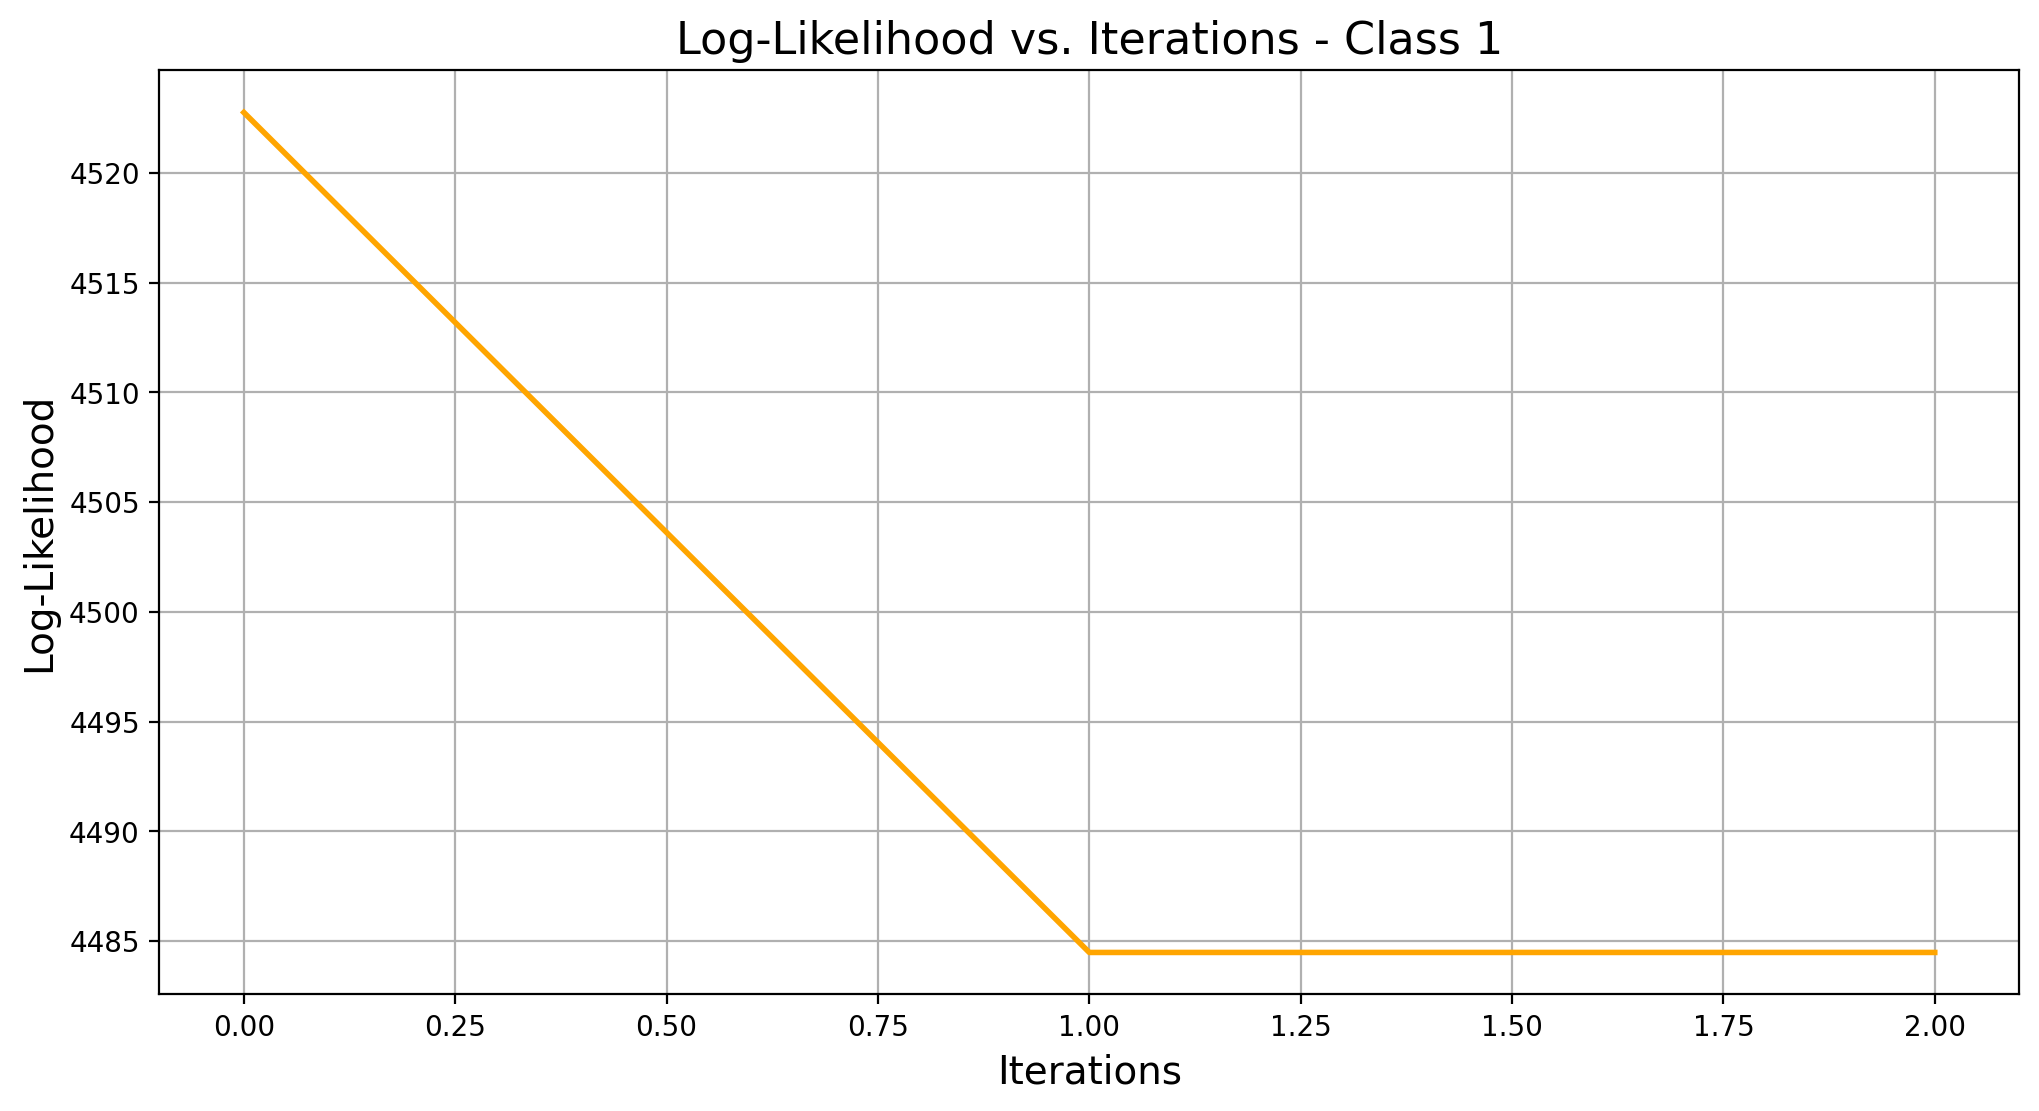

Class 2 converged in 3 iterations.


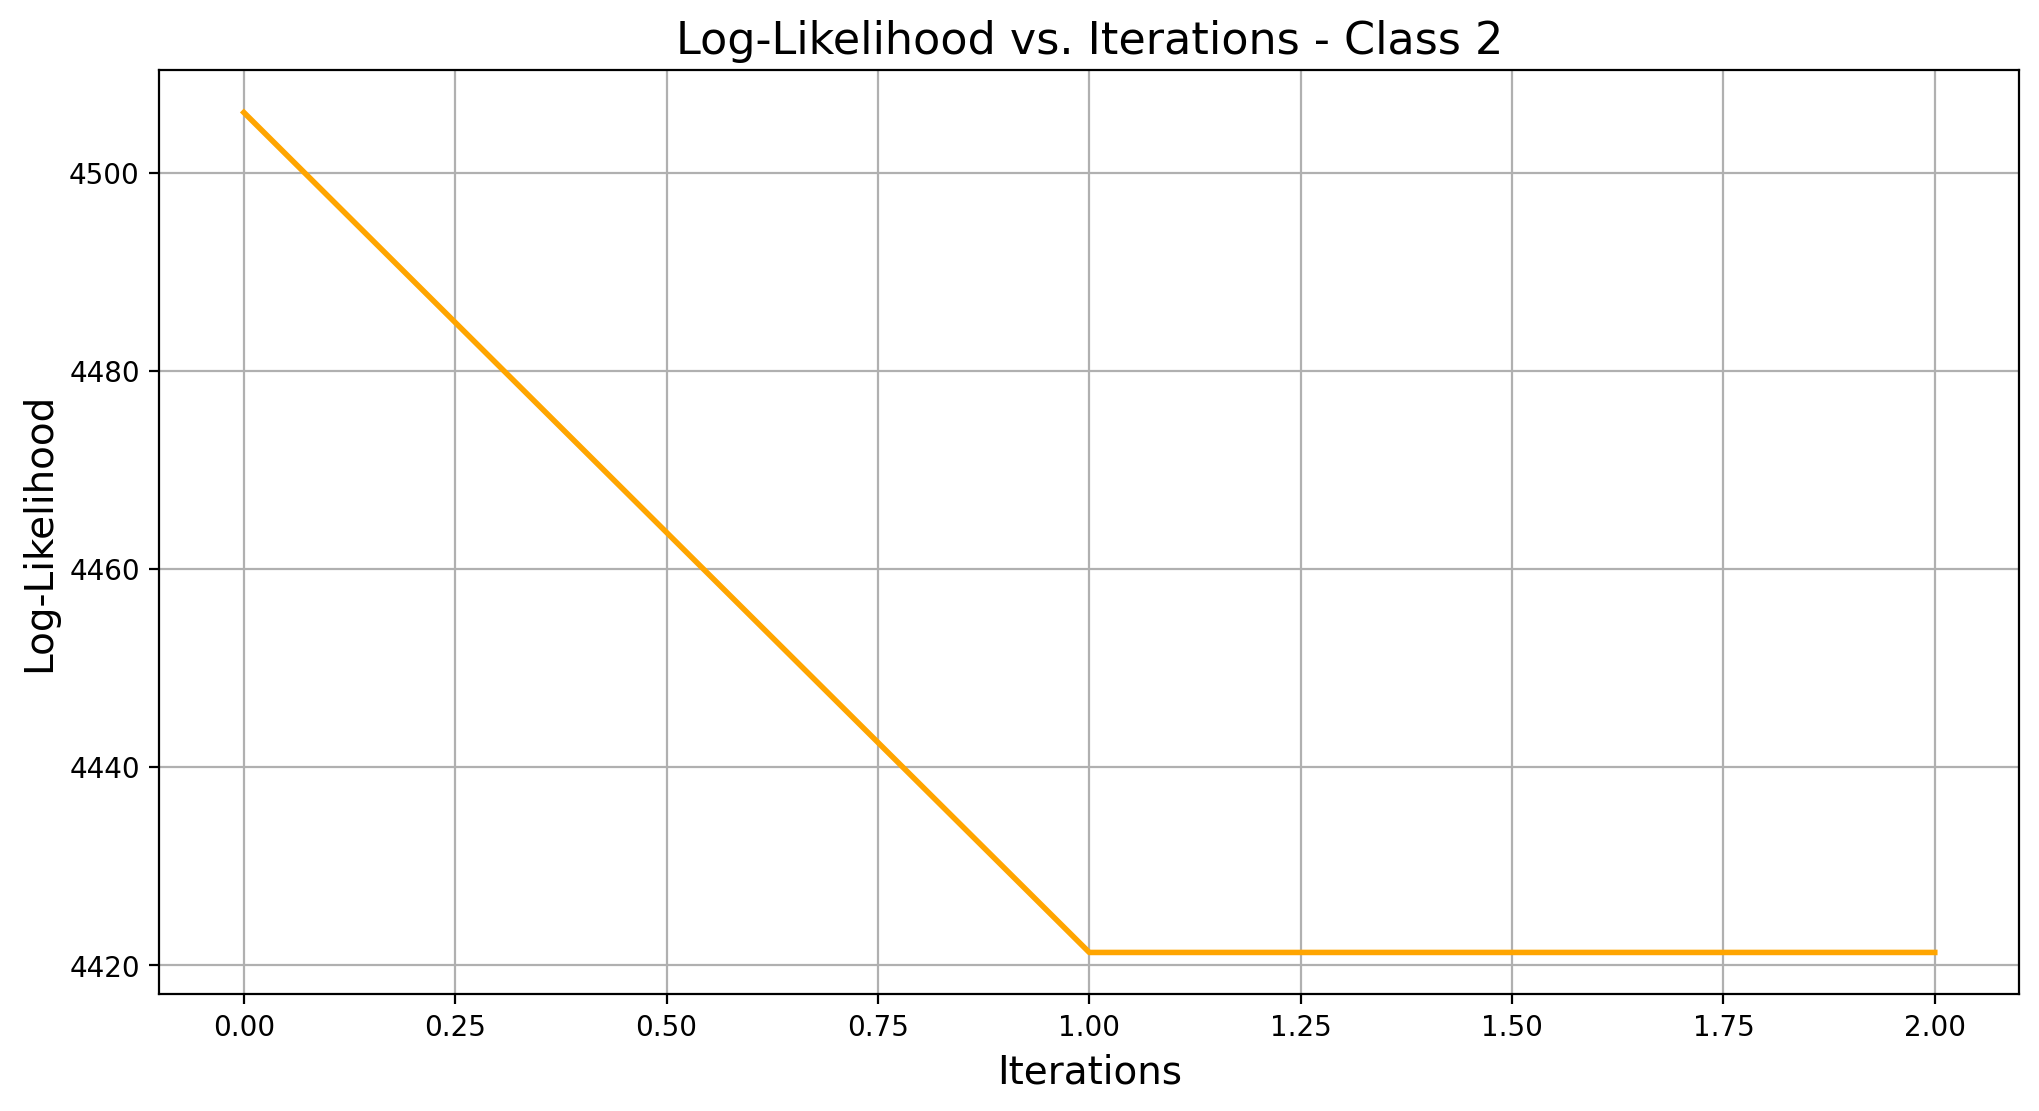

Class 3 converged in 3 iterations.


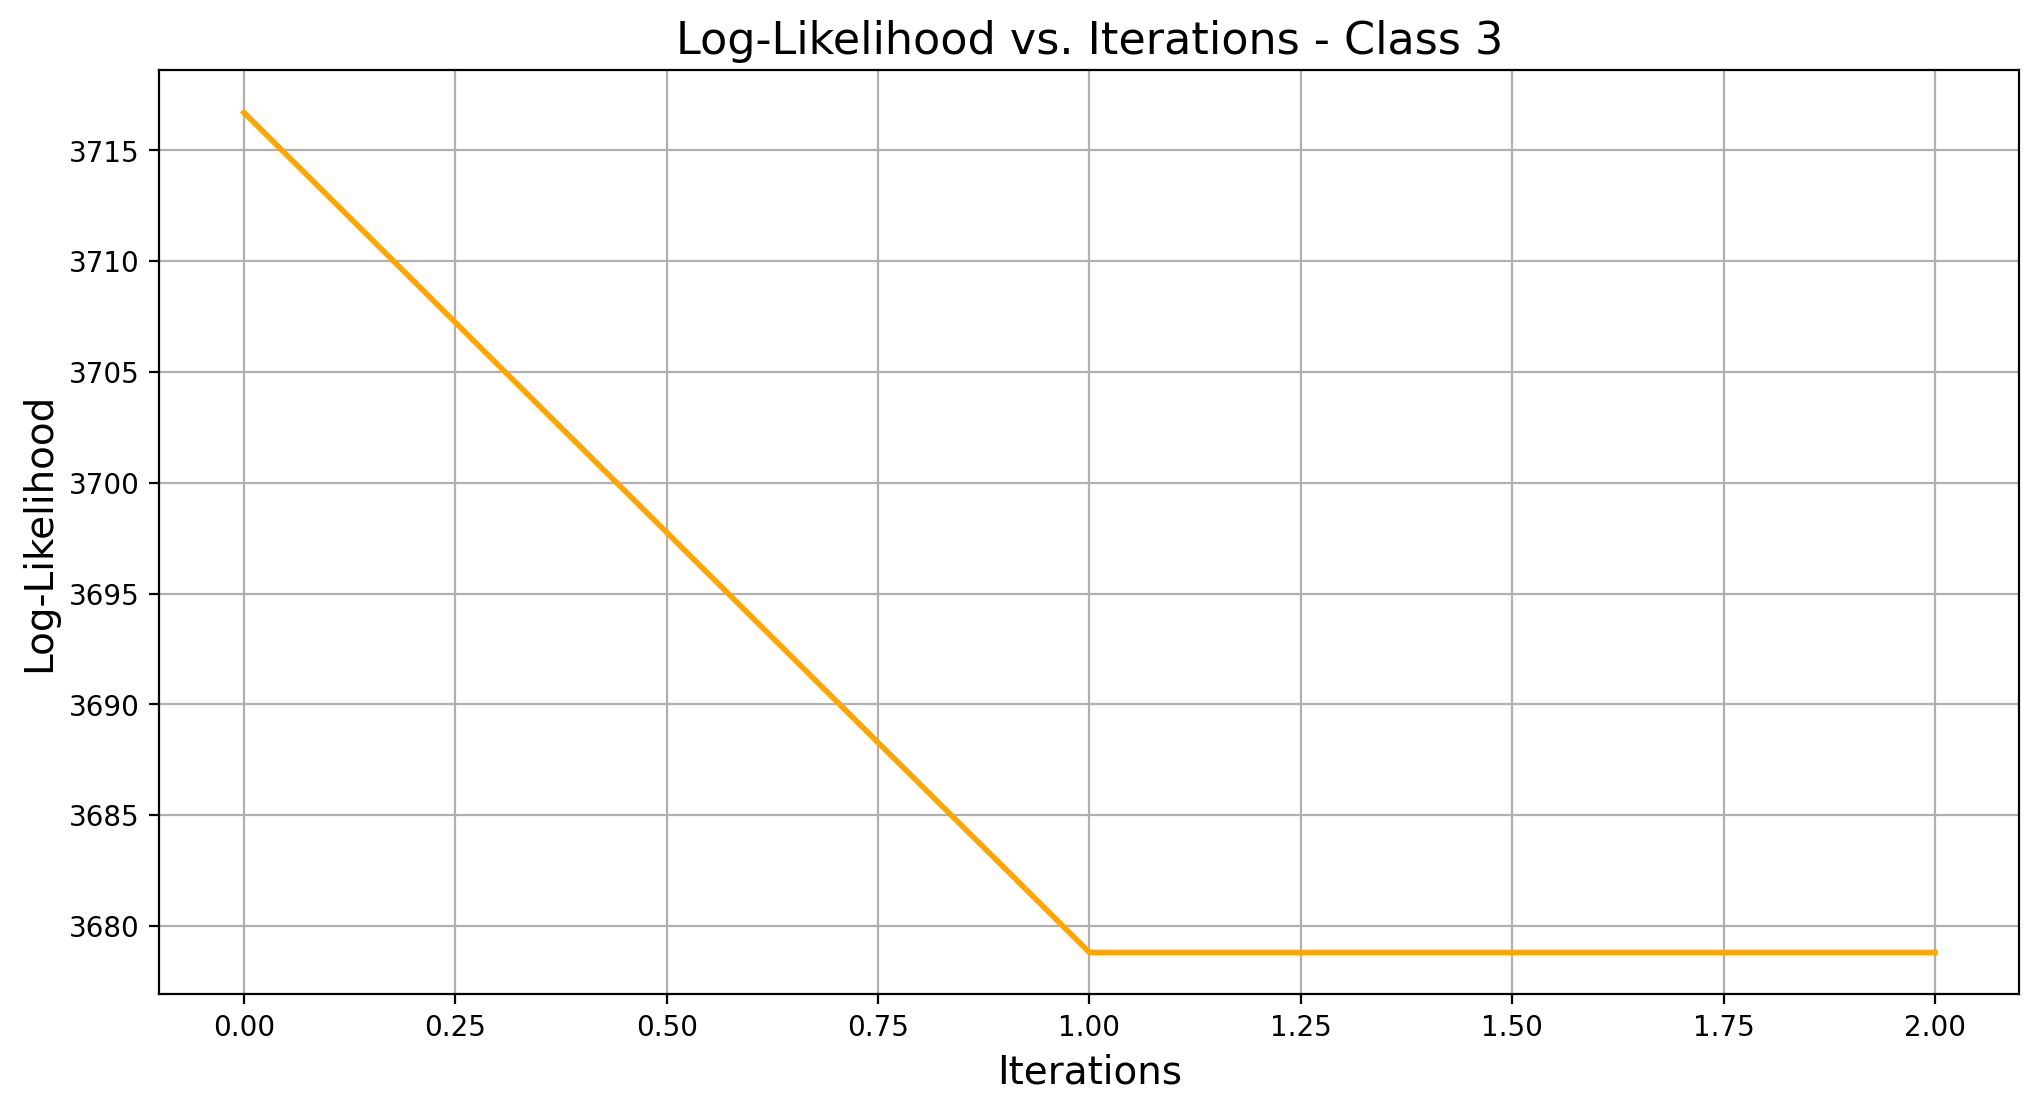

Accuracy: 0.75
Confusion Matrix:
[[37  7  6]
 [ 5 32 13]
 [ 4  3 43]]
Class 1 -> Precision: 0.80, Recall: 0.74, F1-Score: 0.77
Class 2 -> Precision: 0.76, Recall: 0.64, F1-Score: 0.70
Class 3 -> Precision: 0.69, Recall: 0.86, F1-Score: 0.77

for K= 2
Class 1 converged in 3 iterations.


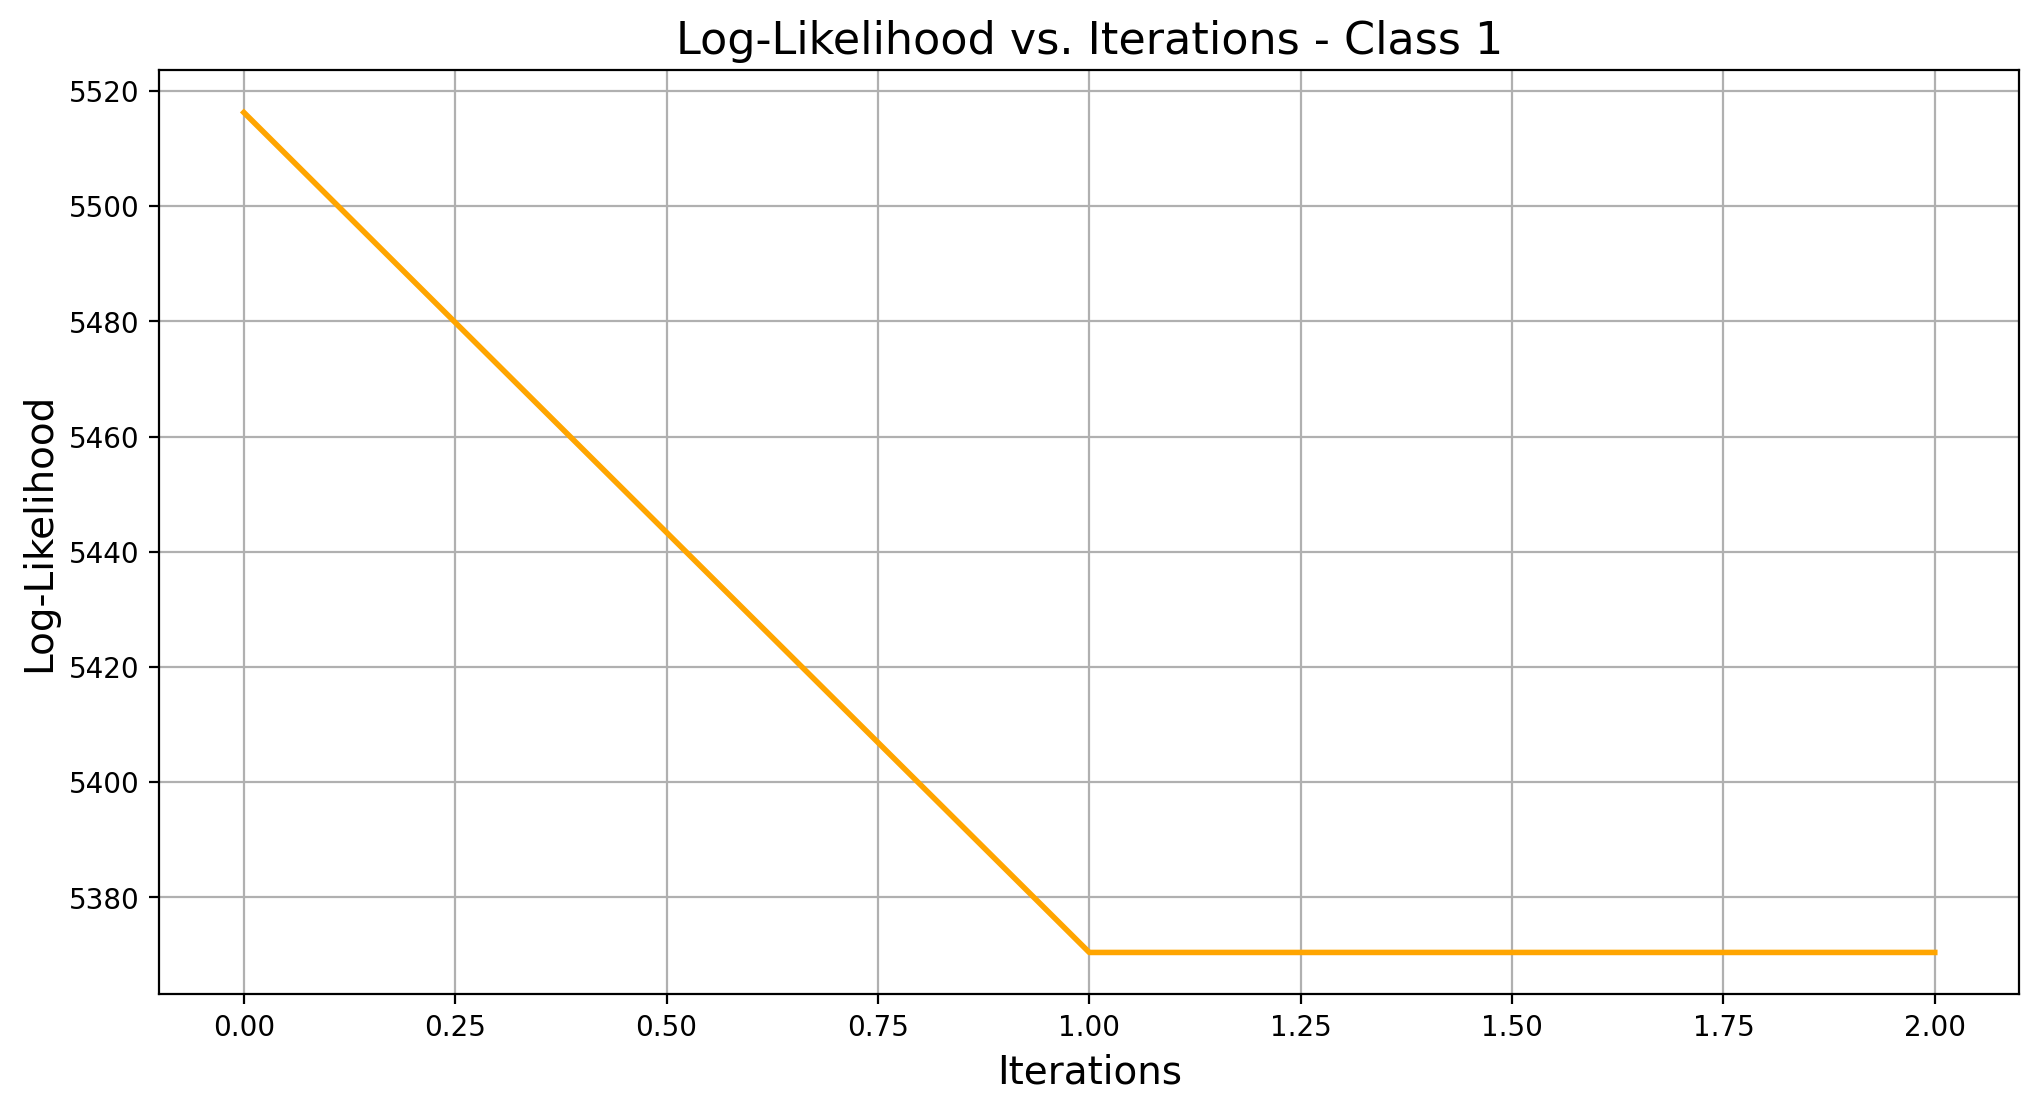

Class 2 converged in 3 iterations.


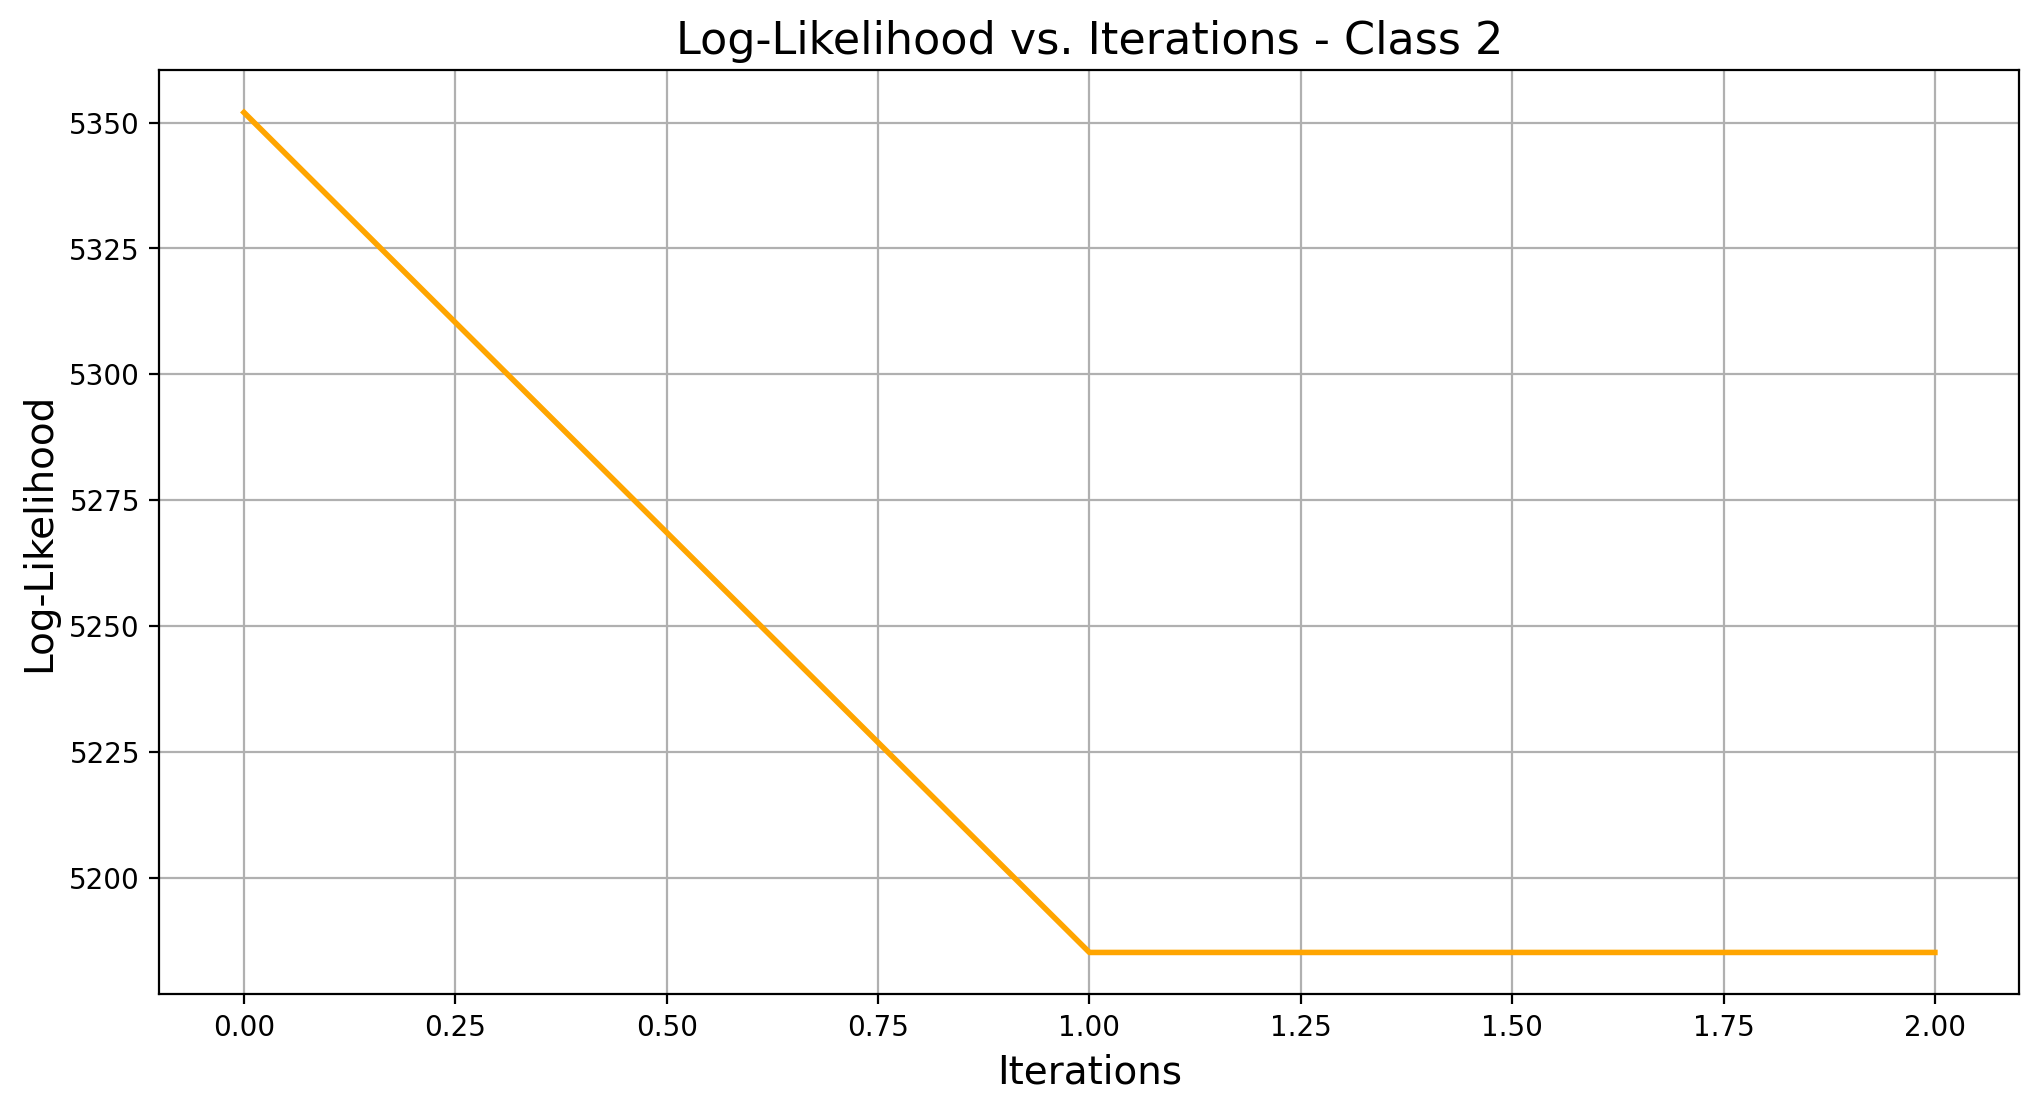

Class 3 converged in 3 iterations.


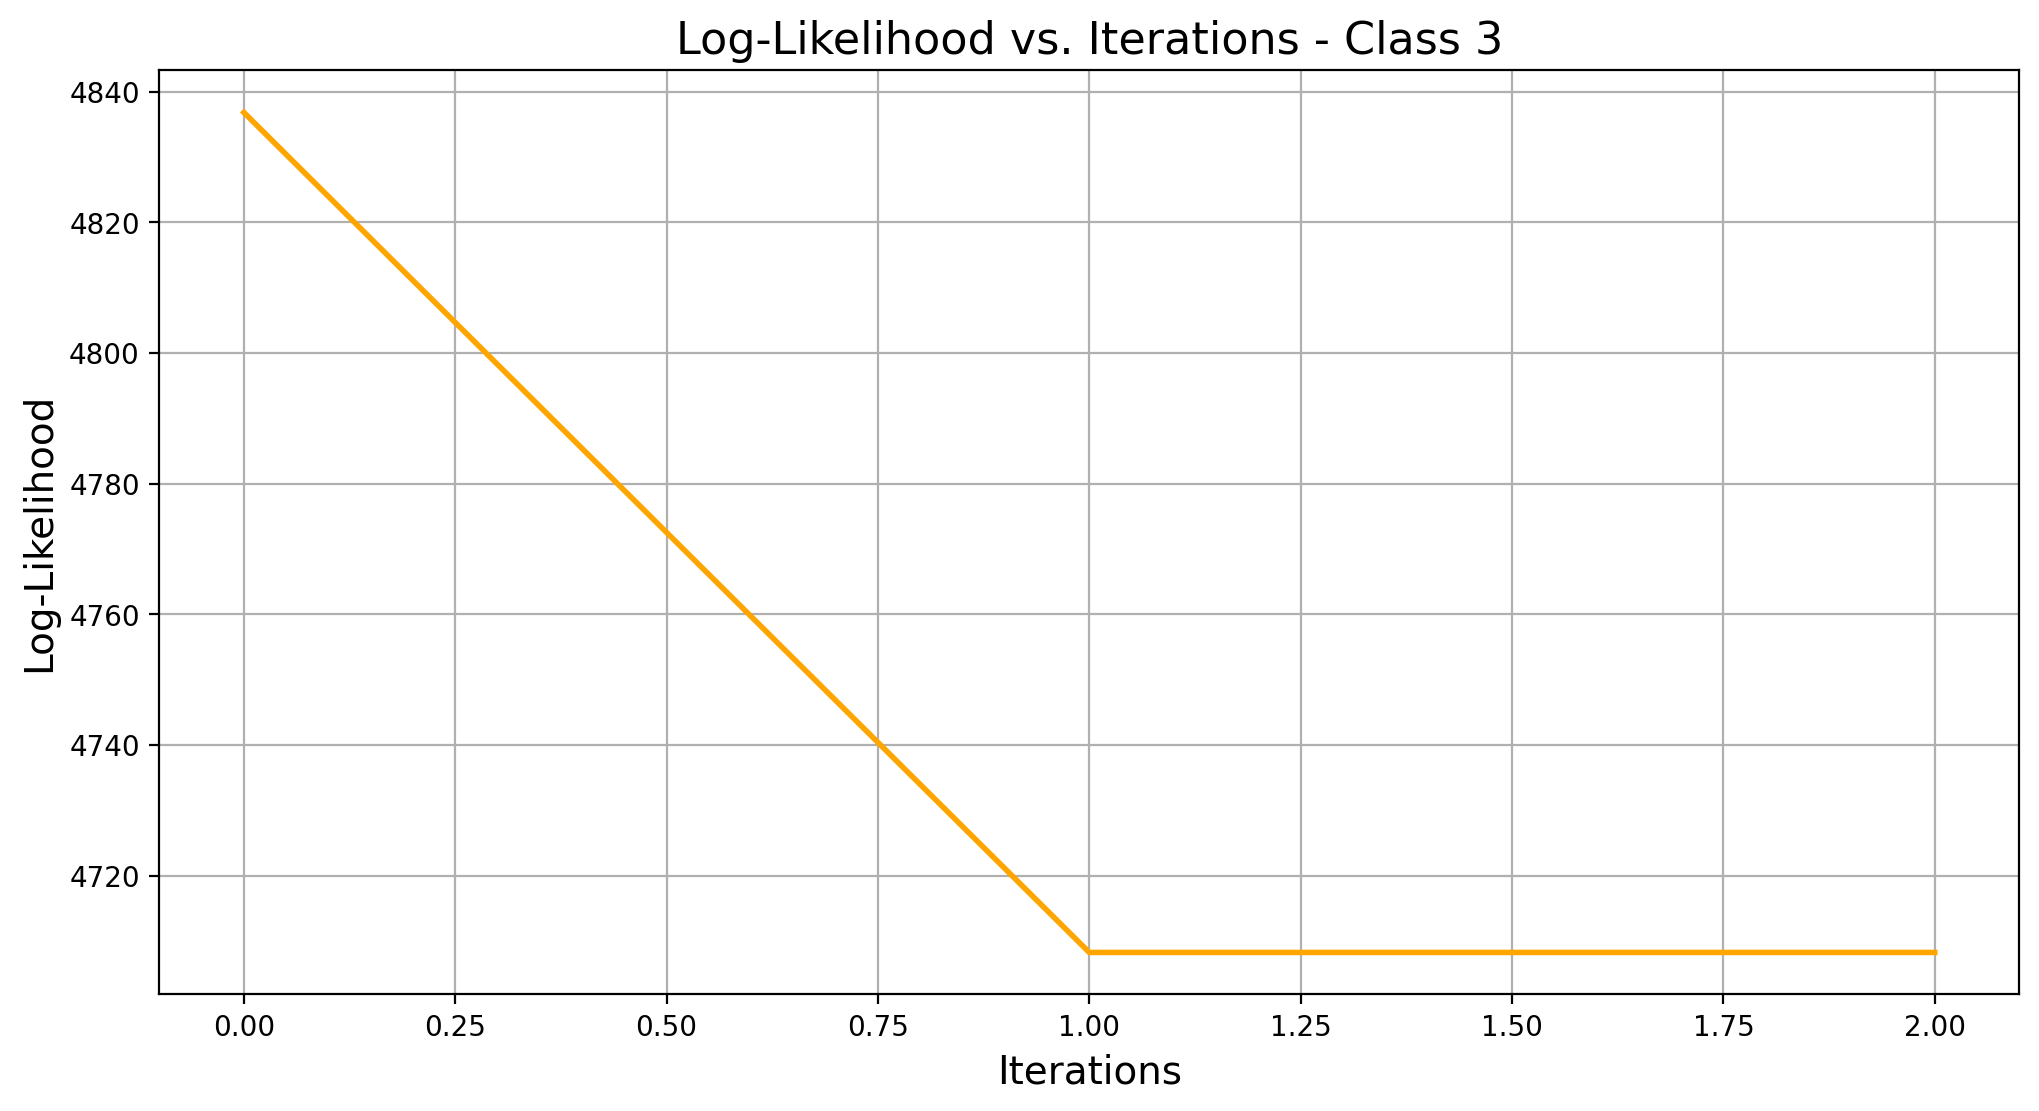

Accuracy: 0.67
Confusion Matrix:
[[31  8 11]
 [ 9 33  8]
 [ 9  5 36]]
Class 1 -> Precision: 0.63, Recall: 0.62, F1-Score: 0.63
Class 2 -> Precision: 0.72, Recall: 0.66, F1-Score: 0.69
Class 3 -> Precision: 0.65, Recall: 0.72, F1-Score: 0.69

for K= 4
Class 1 converged in 3 iterations.


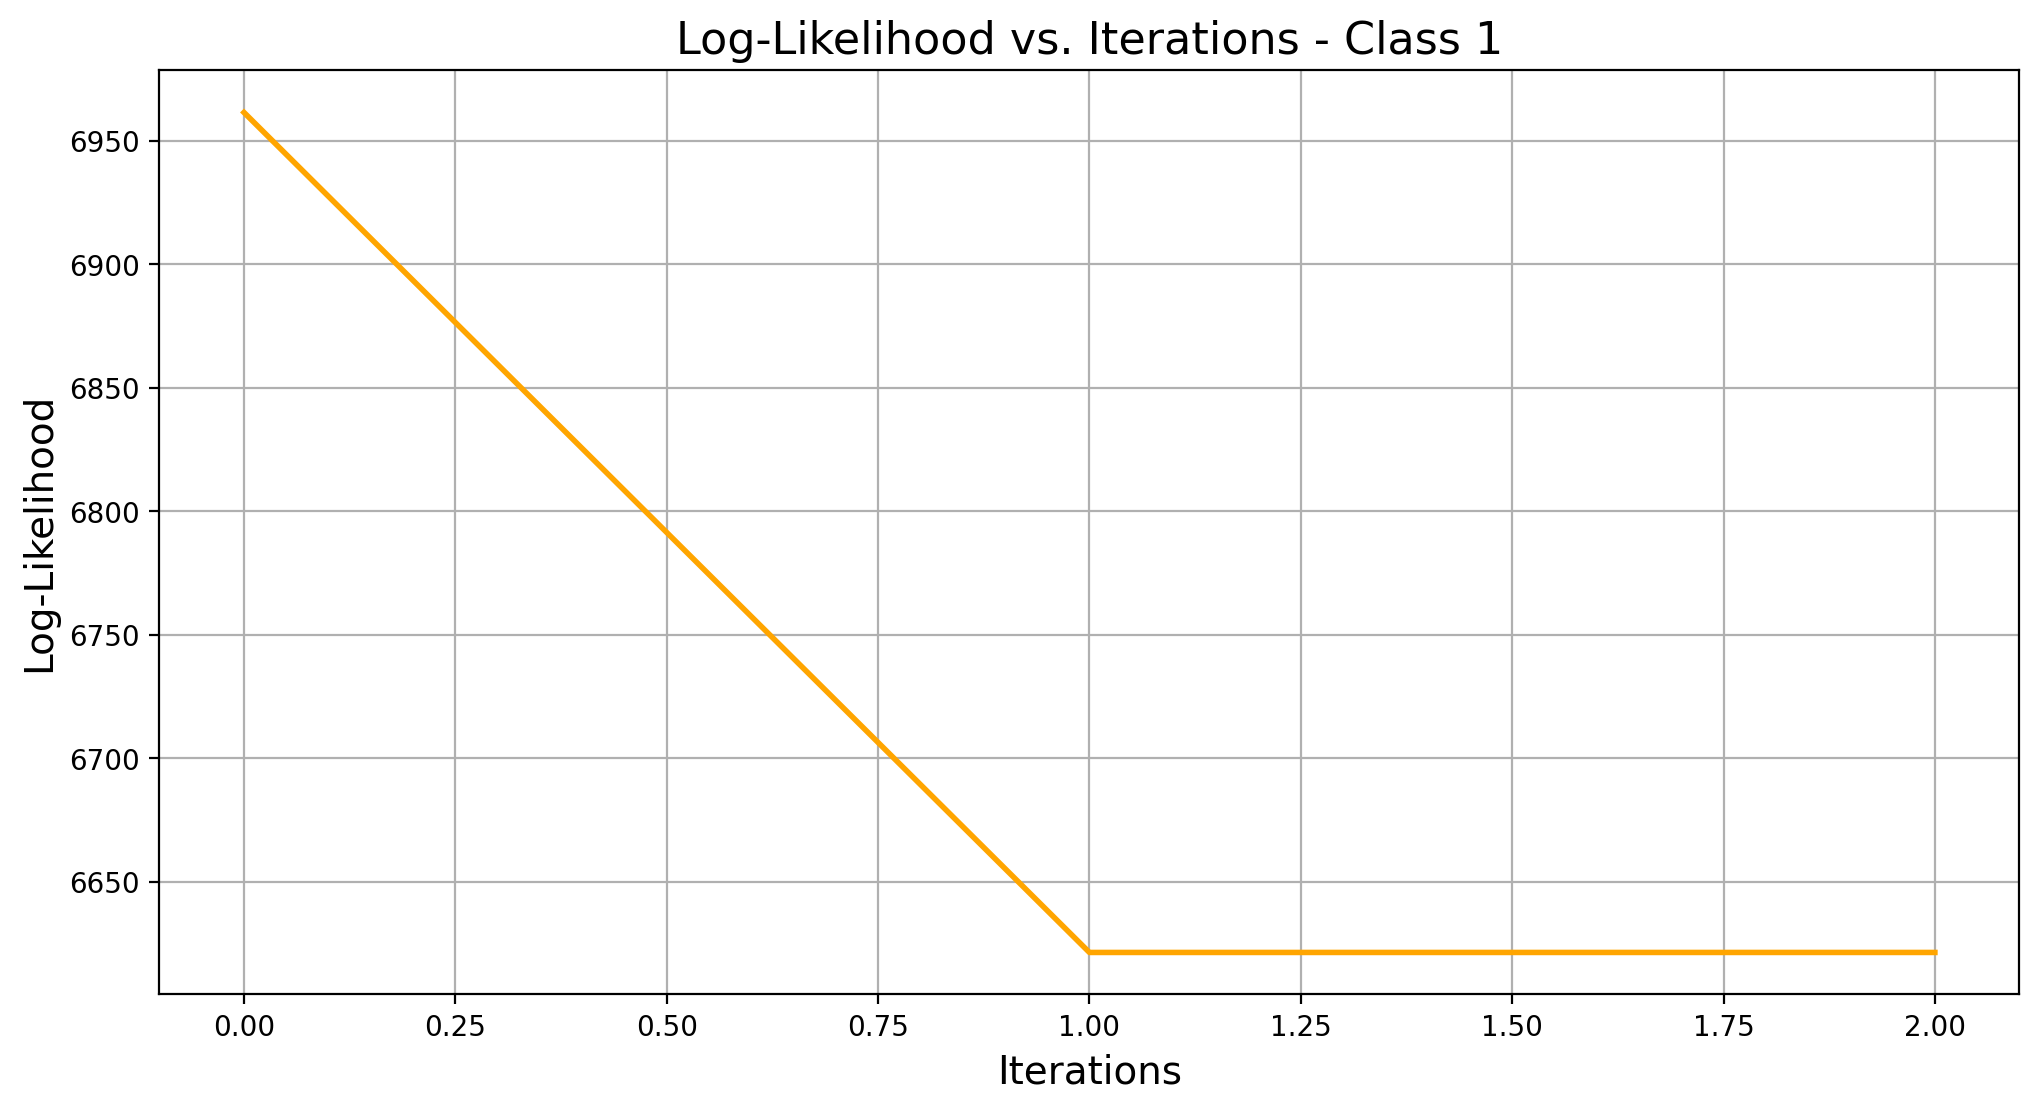

Class 2 converged in 3 iterations.


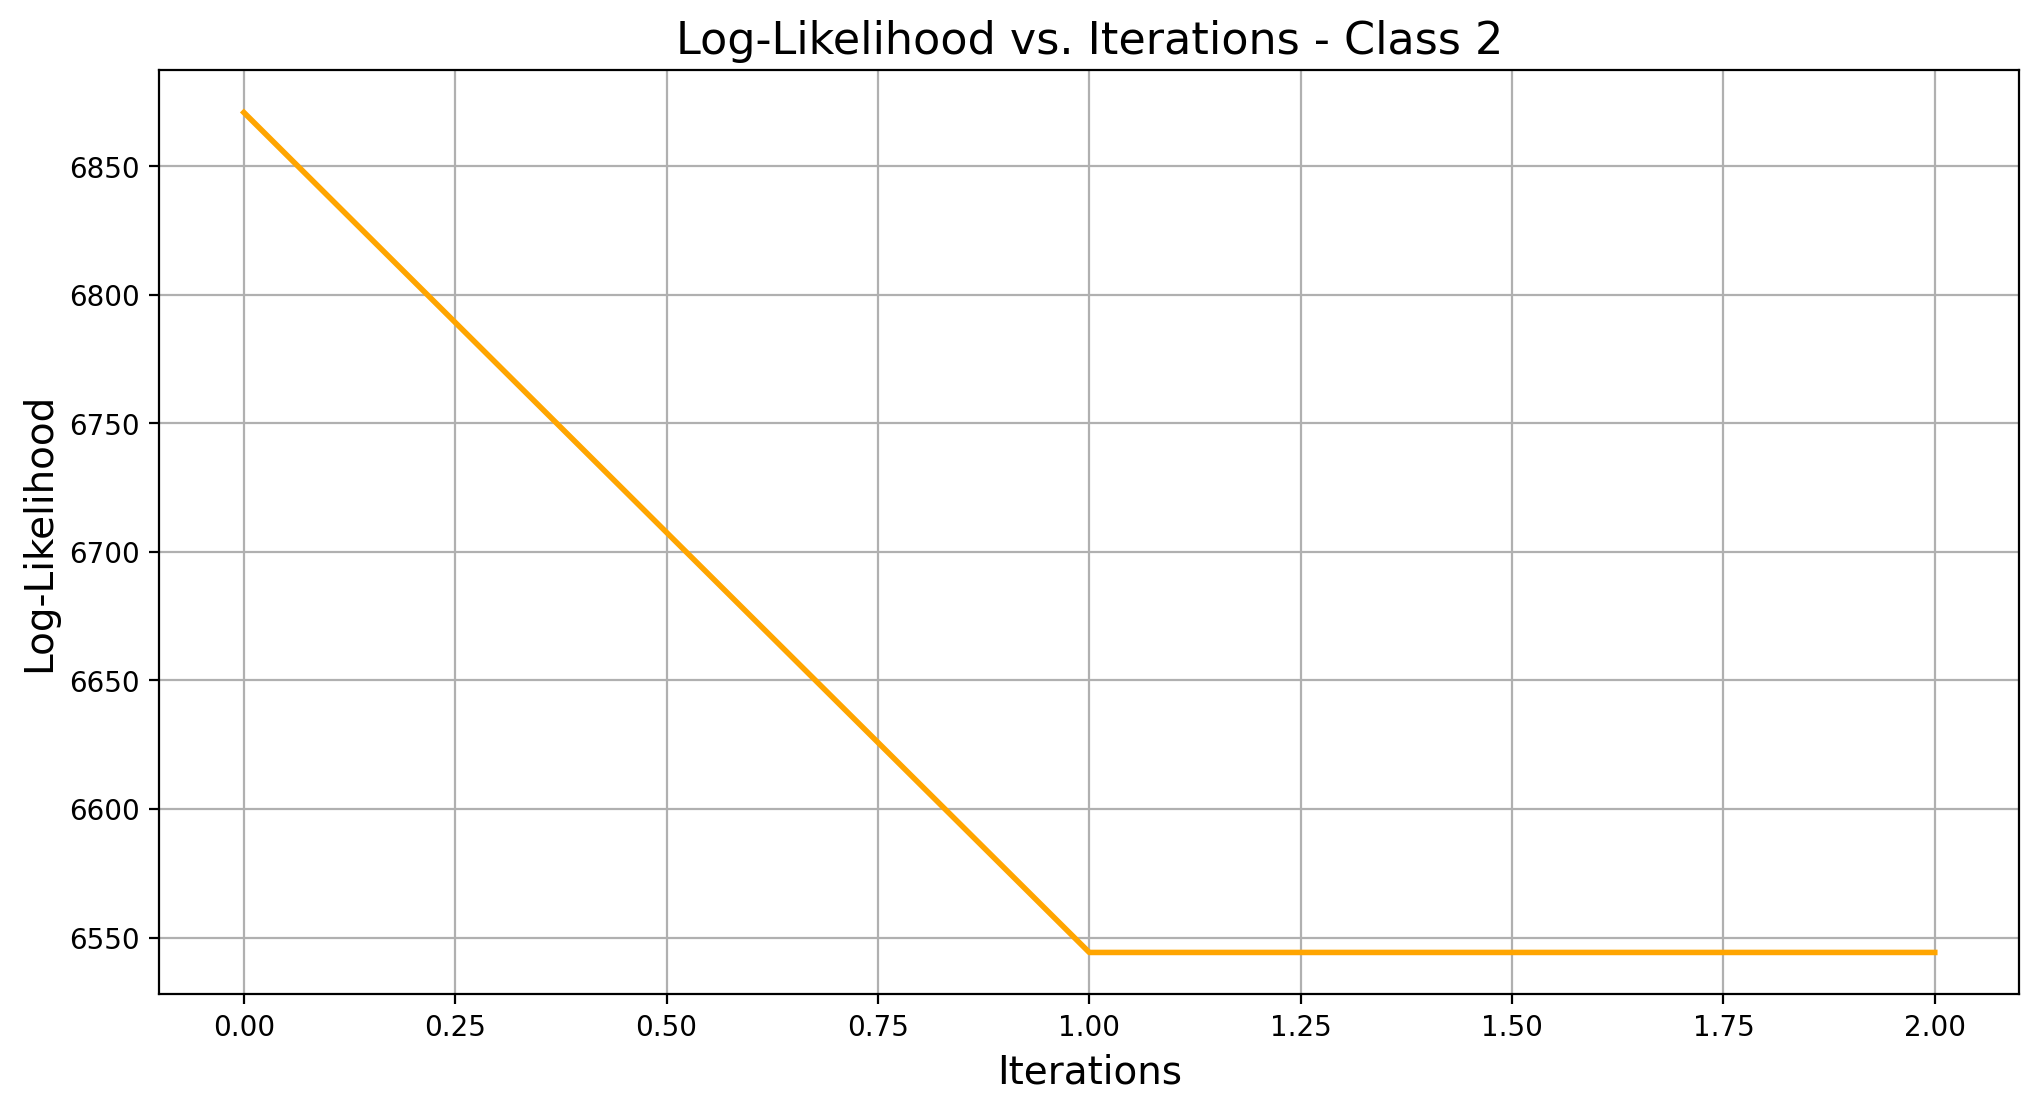

Class 3 converged in 3 iterations.


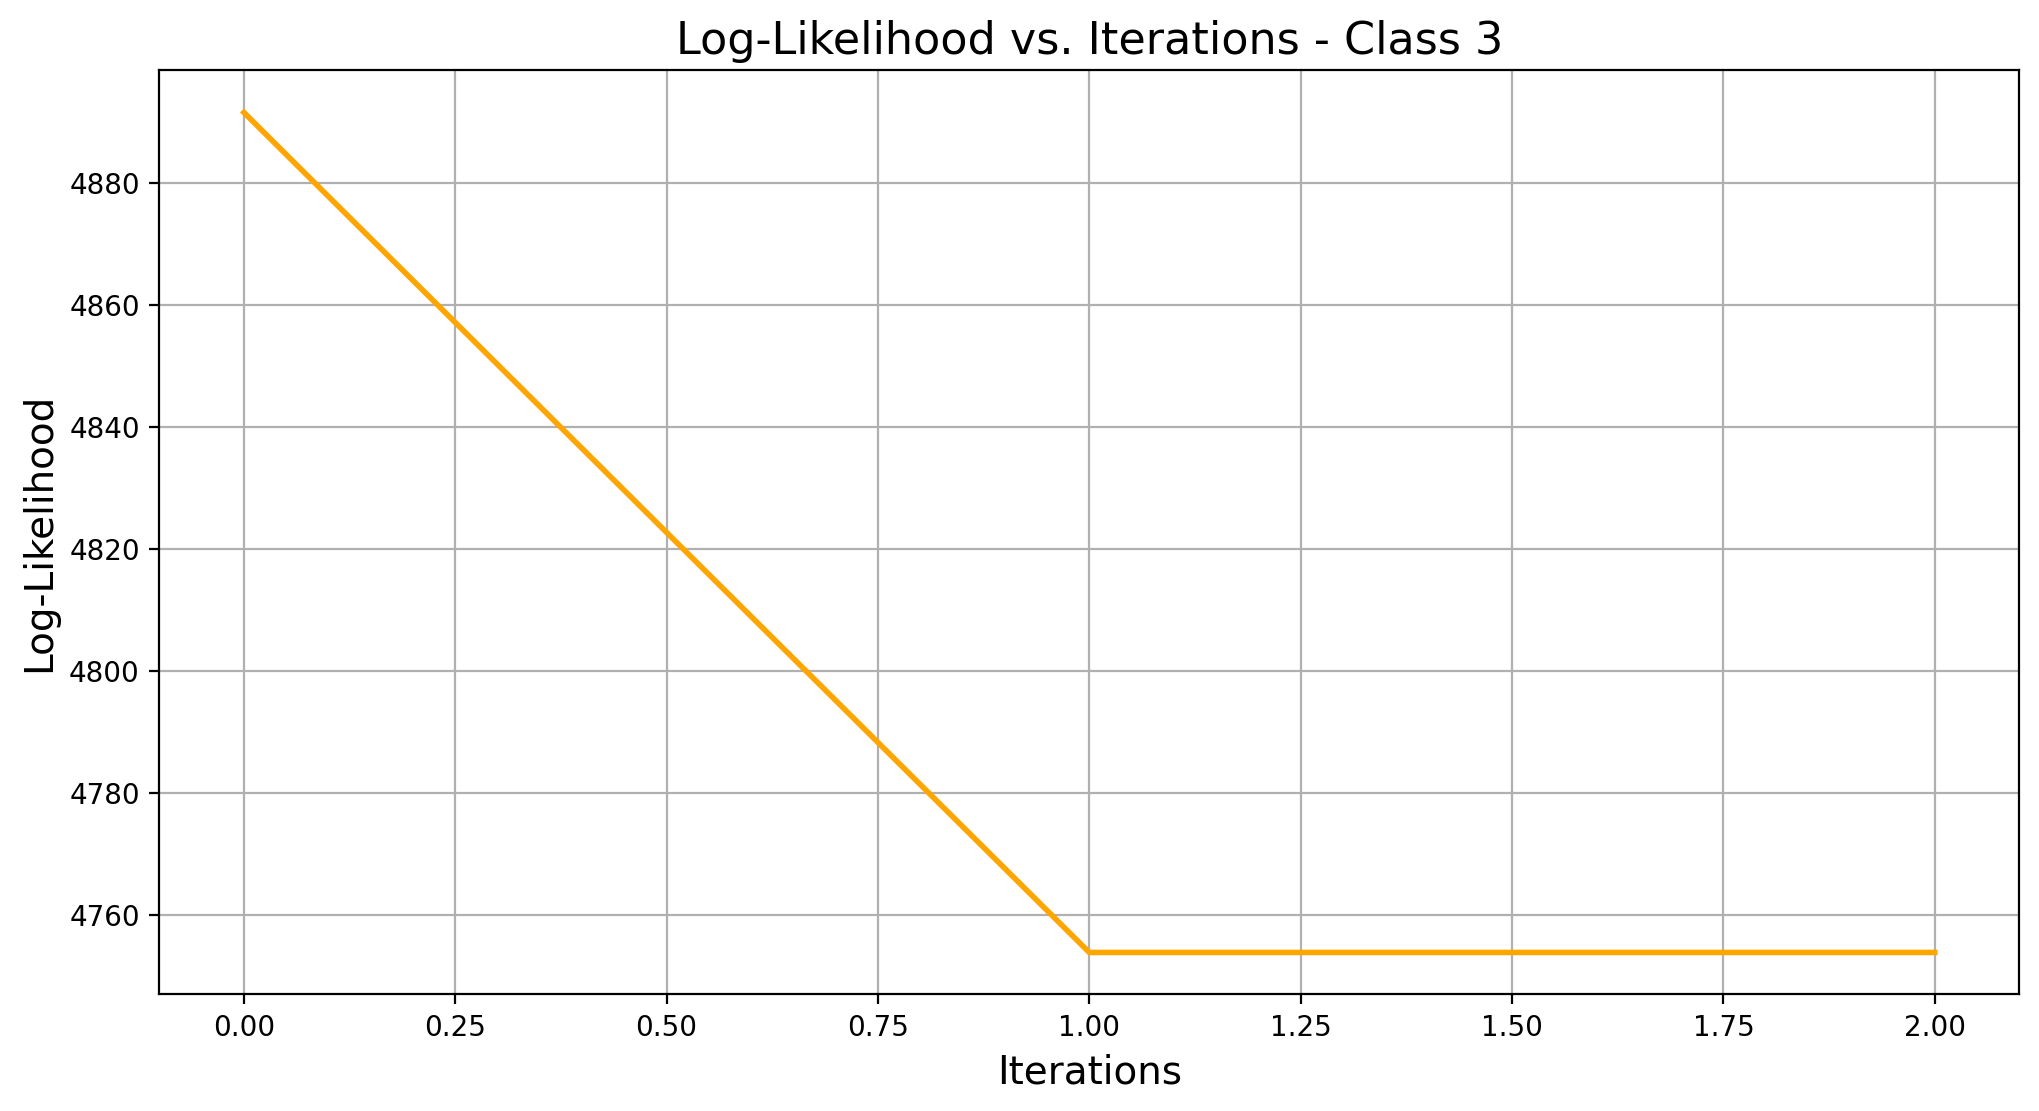

Accuracy: 0.41
Confusion Matrix:
[[ 9  3 38]
 [ 8  4 38]
 [ 1  0 49]]
Class 1 -> Precision: 0.50, Recall: 0.18, F1-Score: 0.26
Class 2 -> Precision: 0.57, Recall: 0.08, F1-Score: 0.14
Class 3 -> Precision: 0.39, Recall: 0.98, F1-Score: 0.56

for K= 8
Class 1 converged in 3 iterations.


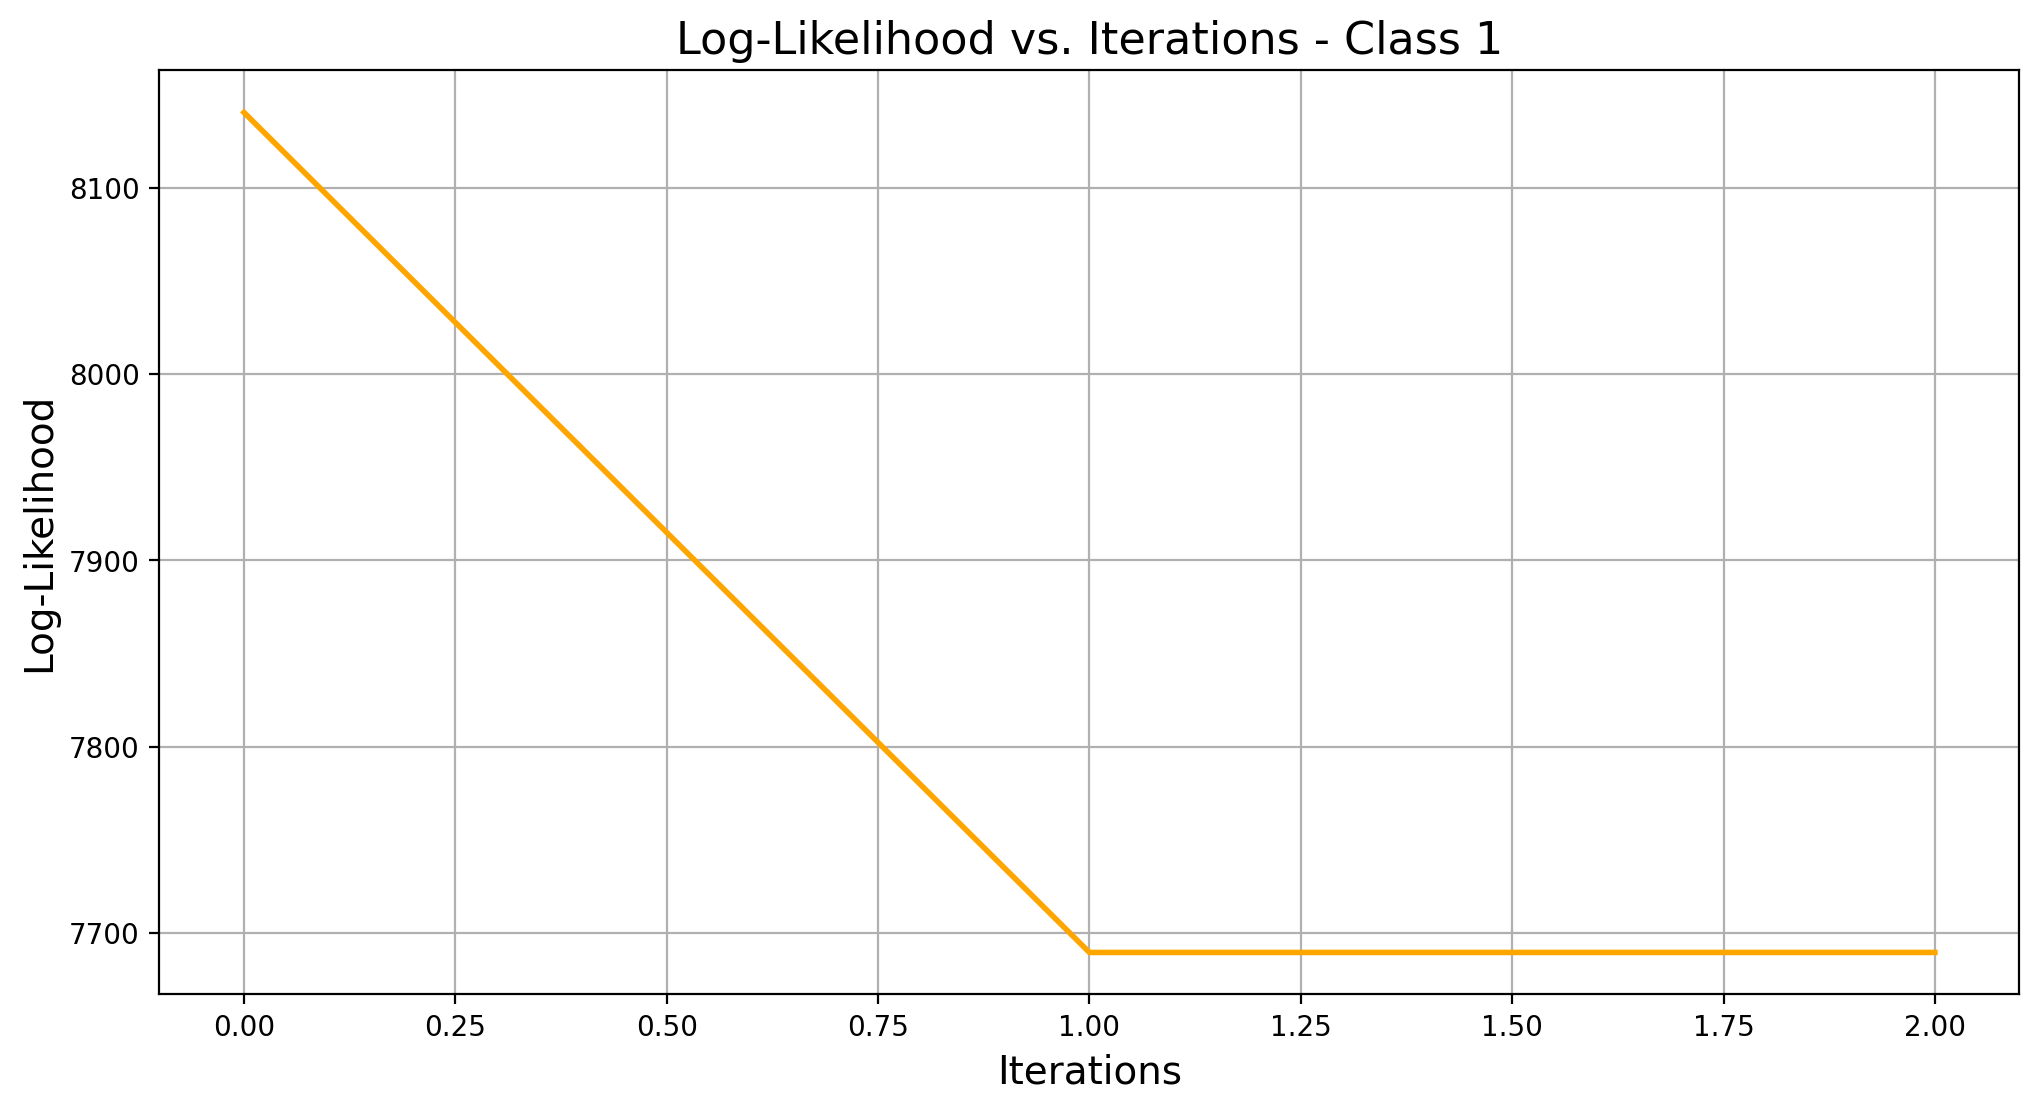

Class 2 converged in 3 iterations.


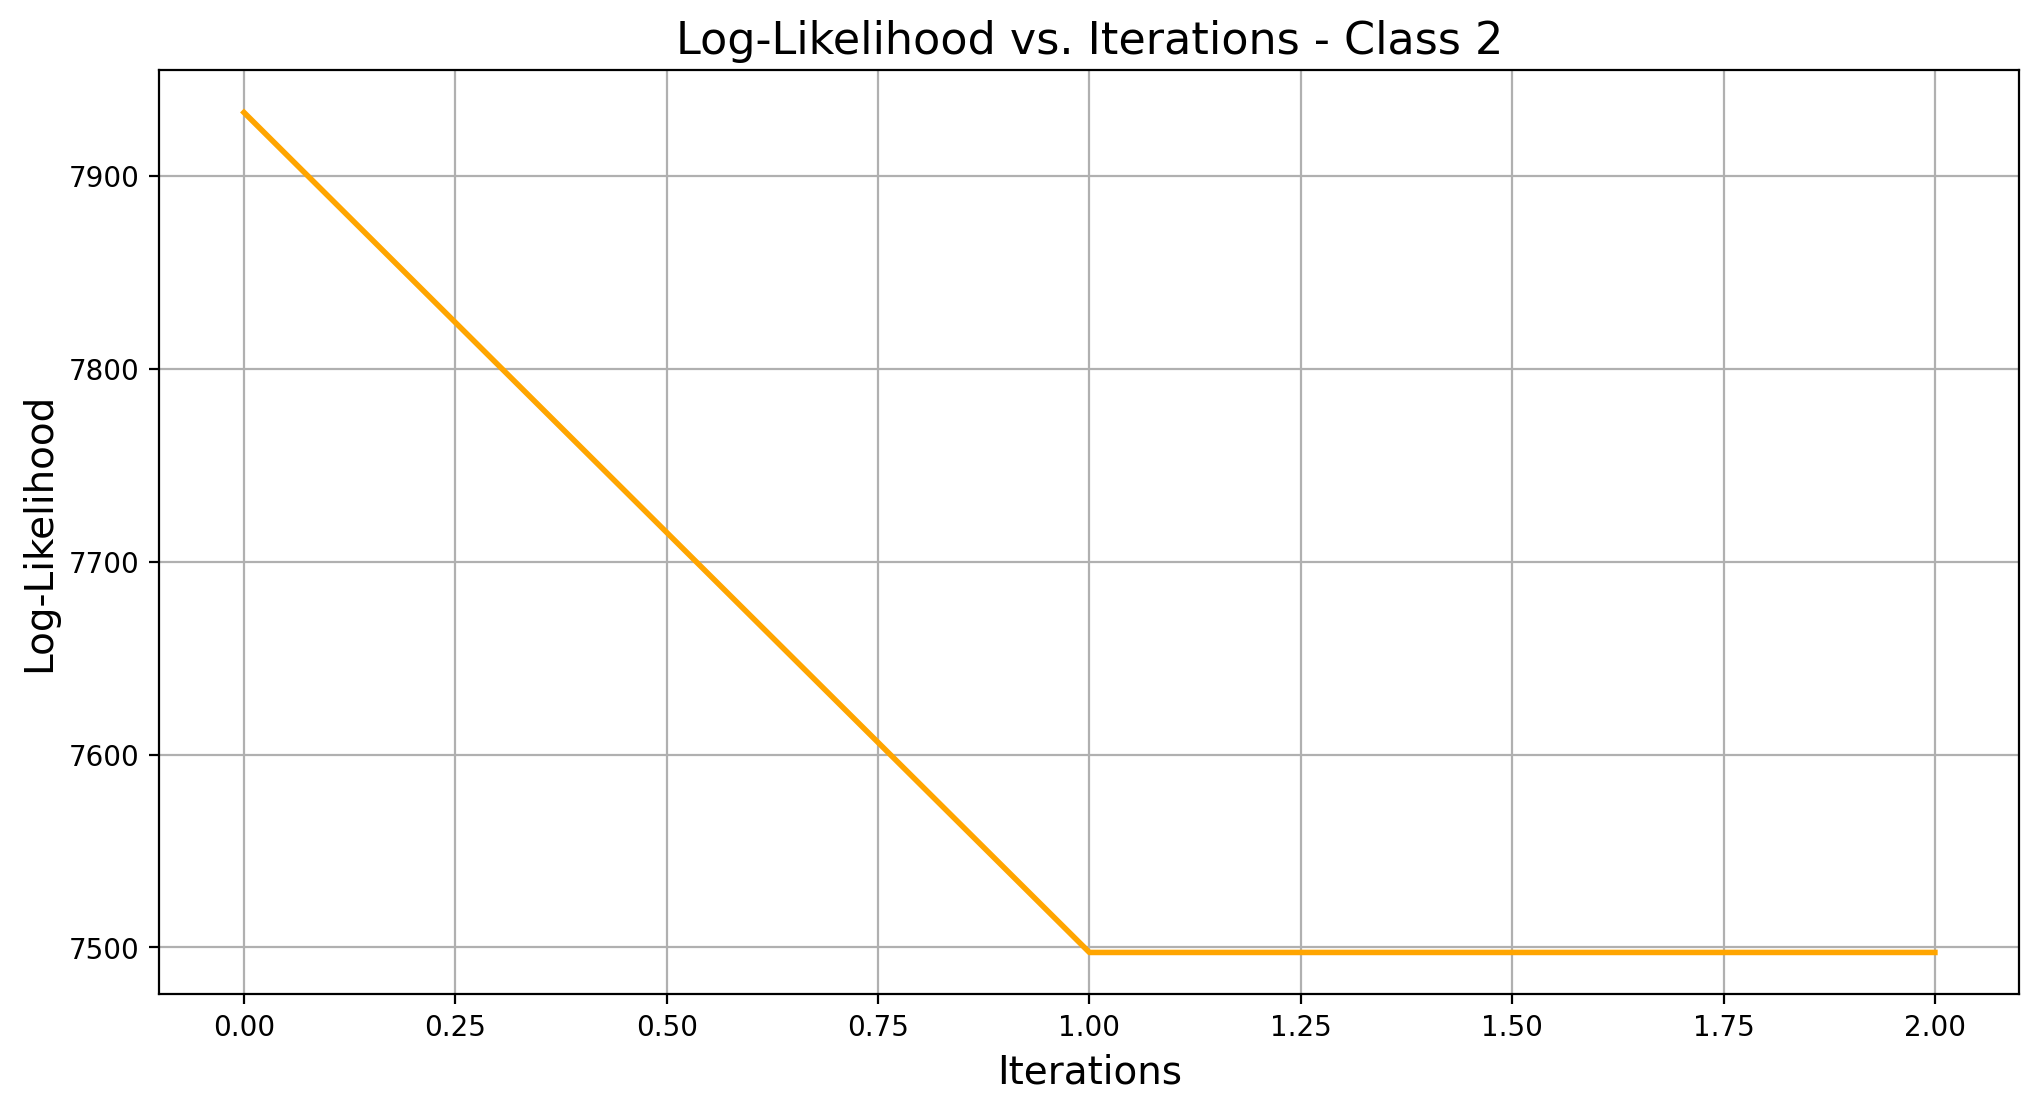

Class 3 converged in 3 iterations.


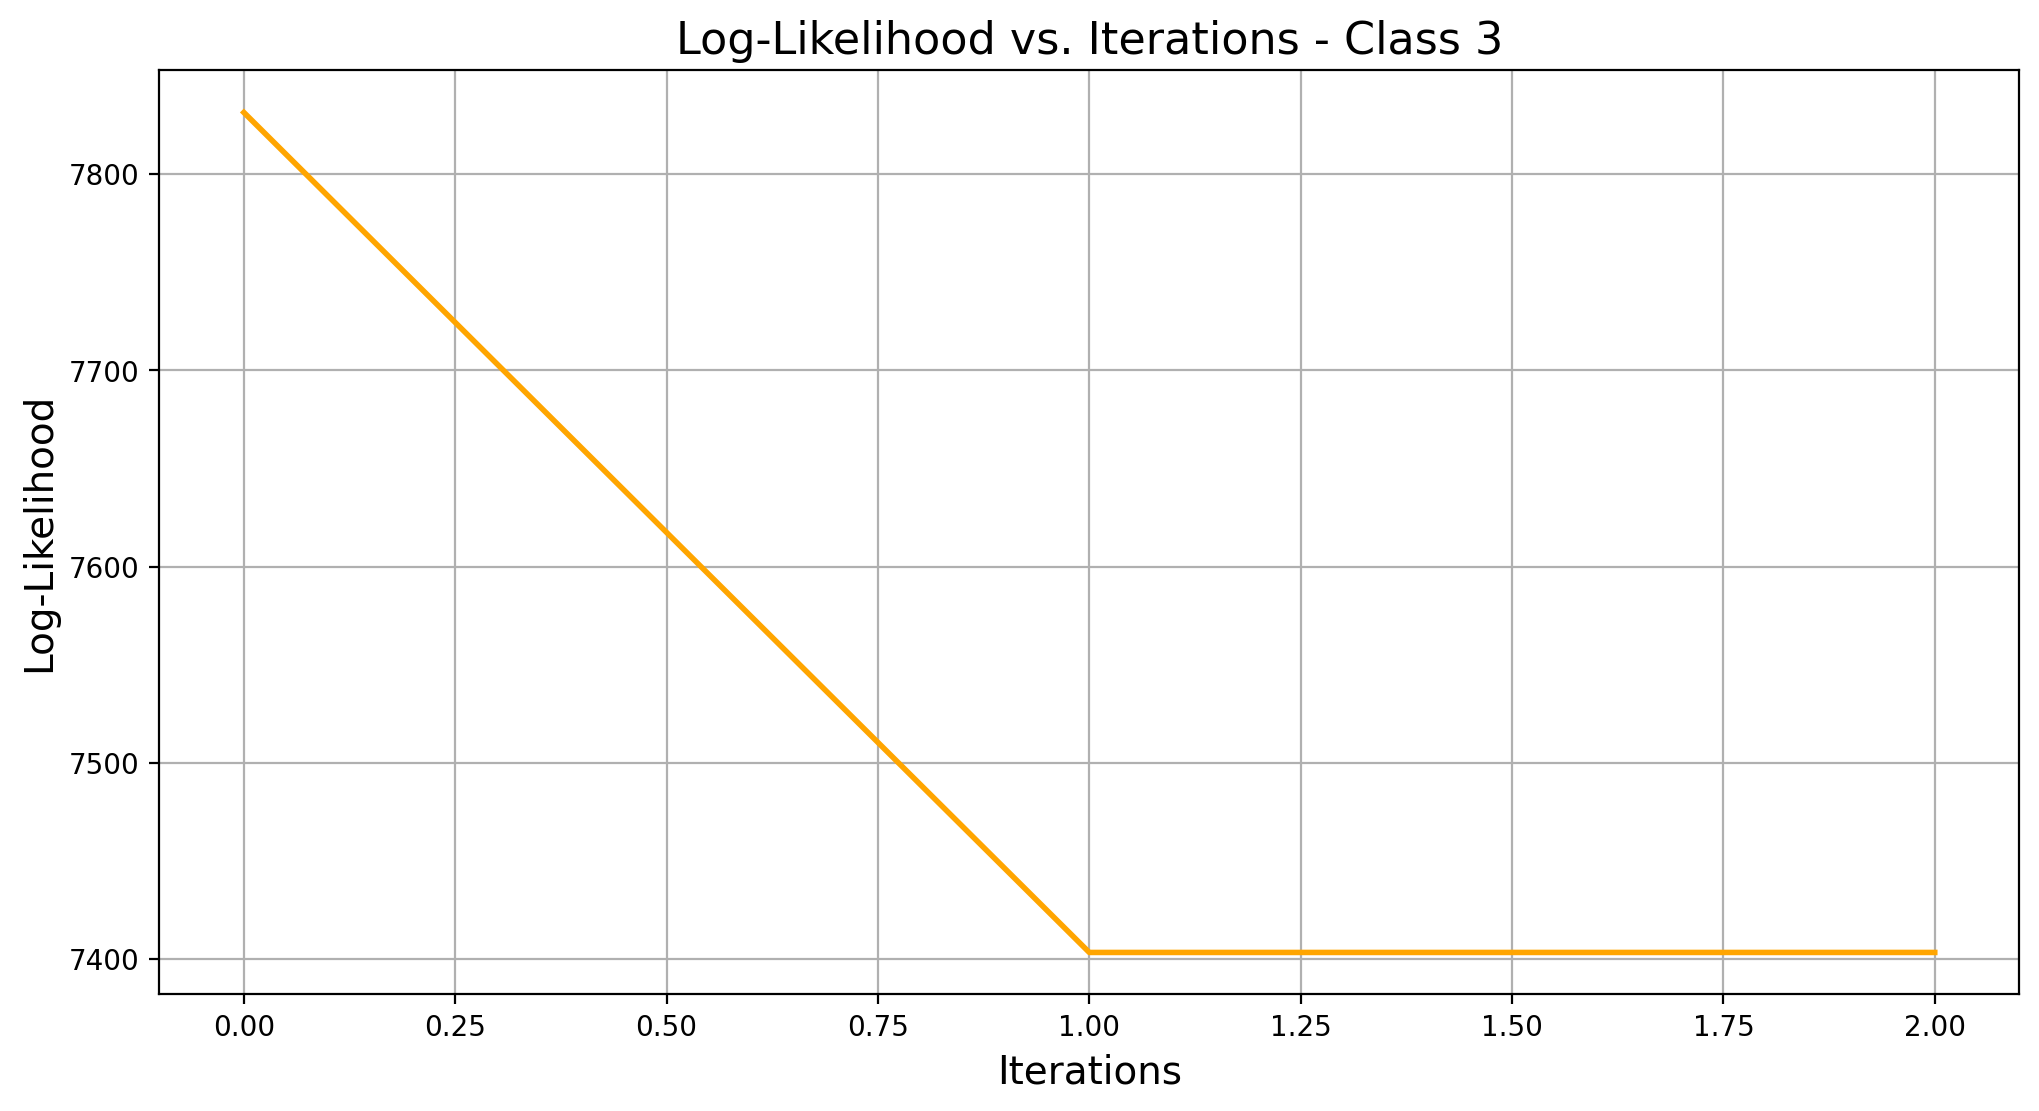

Accuracy: 0.33
Confusion Matrix:
[[50  0  0]
 [50  0  0]
 [50  0  0]]
Class 1 -> Precision: 0.33, Recall: 1.00, F1-Score: 0.50
Class 2 -> Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class 3 -> Precision: 0.00, Recall: 0.00, F1-Score: 0.00



In [18]:
for k in K_set:
    print("for K=",k)
    data1 =np.array(train_data1)
    centroids1, clusters1 = k_means_clustering(k, data1)
    cov_matrices1, cluster_weights1 = compute_cluster_covariance_and_weight(data1, centroids1, clusters1)
    
    data2 =np.array(train_data2)
    centroids2, clusters2 = k_means_clustering(k, data2)
    cov_matrices2, cluster_weights2 = compute_cluster_covariance_and_weight(data2, centroids2, clusters2)
    
    data3 =np.array(train_data3)
    centroids3, clusters3 = k_means_clustering(k, data3)
    cov_matrices3, cluster_weights3 = compute_cluster_covariance_and_weight(data3, centroids3, clusters3)
    
    tolerance=1e-4
    centroids1, cov_matrices1, cluster_weights1, log_likelihoods1, iterations1 = fit_k_gaussians(data1, centroids1, cov_matrices1, cluster_weights1, tolerance)
    print(f"Class 1 converged in {iterations1} iterations.")
    plot_log_likelihood(log_likelihoods1, "Class 1")
    centroids2, cov_matrices2, cluster_weights2, log_likelihoods2, iterations2 = fit_k_gaussians(data2, centroids2, cov_matrices2, cluster_weights2, tolerance)
    print(f"Class 2 converged in {iterations2} iterations.")
    plot_log_likelihood(log_likelihoods2, "Class 2")
    centroids3, cov_matrices3, cluster_weights3, log_likelihoods3, iterations3 = fit_k_gaussians(data3, centroids3, cov_matrices3, cluster_weights3, tolerance)
    print(f"Class 3 converged in {iterations3} iterations.")
    plot_log_likelihood(log_likelihoods3, "Class 3")
    test_labels1 = np.zeros(len(test_data1), dtype=int)
    test_labels2 = np.ones(len(test_data2), dtype=int)
    test_labels3 = np.full(len(test_data3), 2, dtype=int)
    test_data_combined = np.vstack((test_data1, test_data2, test_data3))
    test_labels_combined = np.hstack((test_labels1, test_labels2, test_labels3))
    gmm_params = [[centroids1, cov_matrices1, cluster_weights1], 
              [centroids2, cov_matrices2, cluster_weights2], 
              [centroids3, cov_matrices3, cluster_weights3]]

    predictions = predict_gmm(gmm_params, test_data_combined)
    accuracy = np.mean(predictions == test_labels_combined)
    print(f"Accuracy: {accuracy:.2f}")
    cm = confusion_matrix(test_labels_combined, predictions, num_classes=3)
    print("Confusion Matrix:")
    print(cm)
    precision, recall, f1 = precision_recall_f1(cm)
    for i in range(3):
        print(f"Class {i+1} -> Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1[i]:.2f}")
    print()  

